In [10]:
import os

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary as summary
from IPython import display
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [11]:
folder_benign_train = './data/train/benign/'
folder_malignant_train = './data/train/malignant/'

folder_benign_test = './data/test/benign/'
folder_malignant_test = './data/test/malignant/'


def load_data(folder_benign, folder_malignant):
    def read_image(file): return plt.imread(file)
    img_benign = [read_image(folder_benign + file)
                  for file in os.listdir(folder_benign)]
    img_malignant = [read_image(folder_malignant + file)
                     for file in os.listdir(folder_malignant)]
    
    X = np.array(img_benign + img_malignant)
    y = np.array([0] * len(img_benign) + [1] * len(img_malignant))
    return X, y


X_train, y_train = load_data(folder_benign_train, folder_malignant_train)
X_test, y_test = load_data(folder_benign_test, folder_malignant_test)


In [12]:
X_train.shape

(2637, 224, 224, 3)

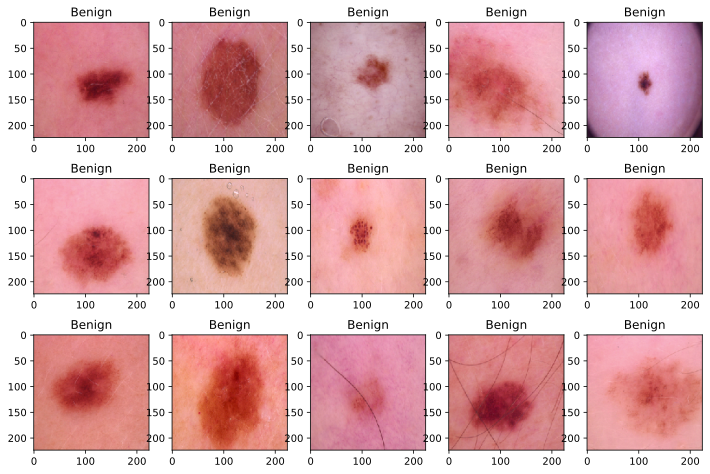

In [13]:
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [14]:
X_train = X_train/255
X_test = X_test/255


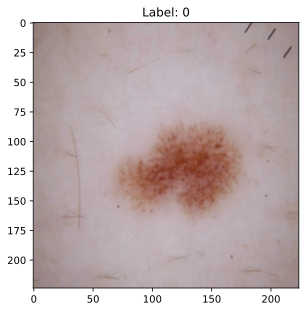

In [15]:
plt.imshow(X_train[200], cmap='gray')
plt.title('Label: {}'.format(y_train[0]))

# reshape into 224*224 3 band image
X_train = X_train.reshape(-1, 3, 224, 224)
X_test = X_test.reshape(-1, 3, 224, 224)

In [16]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=True)

In [17]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.expectsize = 64*56*56
        self.fc1 = nn.Linear(self.expectsize, 128)
        self.fc2 = nn.Linear(128, 2)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.expectsize)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = Model()
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [18]:
def train_model():
    epochs = 20
    losses = np.zeros(epochs)
    train_acc = []
    test_acc = []
    for epoch in range(epochs):
        model.train()
        batchacc = []
        batchloss = []
        for batch in train_loader:
            X, y = batch
            optimizer.zero_grad()
            yhat = model(X)
            loss = lossfun(yhat, y)
            loss.backward()
            optimizer.step()
            batchloss.append(loss.item())
            batchacc.append((yhat.argmax(1) == y).float().mean())
        losses[epoch] = np.mean(batchloss)
        train_acc.append(np.mean(batchacc))
        model.eval()
        batchacc = []
        for batch in test_loader:
            X, y = batch
            yhat = model(X)
            batchacc.append((yhat.argmax(1) == y).float().mean())
        test_acc.append(np.mean(batchacc))
        display.clear_output(wait=True)
        print(f'Epoch: {epoch+1}/{epochs}')
        print(f'Train loss: {losses[epoch]:.4f}')
    return losses, train_acc, test_acc, model


loss, train_acc, test_acc, model = train_model()


Epoch: 20/20
Train loss: 0.1645


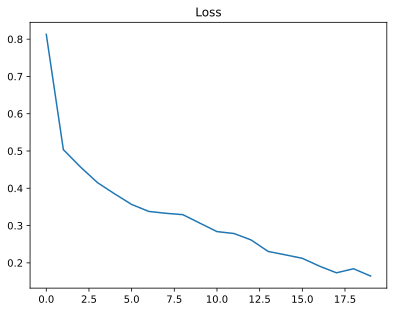

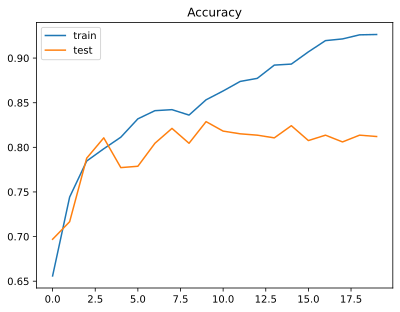

In [19]:
plt.plot(loss)
plt.title('Loss')
plt.show()

plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.title('Accuracy')
plt.legend()
plt.show()

In [20]:
torch.save(model.state_dict(), 'trainedModel.pt')
